In [1]:
import os
import pandas as pd
import numpy as np
import librosa 
from librosa.display import specshow
from IPython.display import Audio
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings; warnings.simplefilter('ignore', FutureWarning)
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils import to_categorical
from glob import glob
import re
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from itertools import islice

def parse_shape(shape_str):
    """Shape was saved in feature_shapes as a string. Woops.
       Convenience funtion to parse out the values. """
    a,b = re.search('\((\d+), (\d+)\)',shape_str).groups()
    return int(a), int(b)

def log_clipped(a):
    """Convenience function to clip the input to positive values then return the log.""" 
    return np.log(np.clip(a,.0000001,a.max()))

""" Datasets """
# sg_dir = "data/features/"
# sglog_dir = "data/features/"
# mfcc_dir = "data/features/"

shapes_df = pd.read_csv("data/feature_shapes.csv",
                        index_col=0 )
# Parse the length from the melspectrogram_shape field, which was inadvertantly saved as a string
train_df = pd.read_csv("data/train_file_ids.csv",
                       index_col=0)
test_df = pd.read_csv("data/test_file_ids.csv",
                      index_col=0)


Using TensorFlow backend.


The dataset contains 91 distinct species labels.
2730 mp3s found in data/audio/


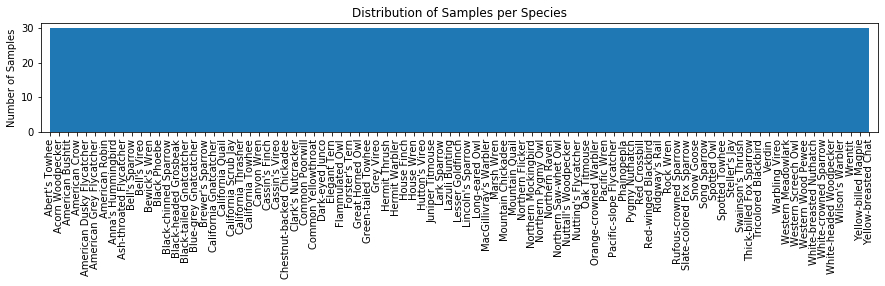

In [2]:
data_dir = 'data/audio/'
df = pd.read_csv("data/xeno-canto_ca-nv_index.csv", 
                 index_col='file_id')
label_encoder = LabelEncoder().fit(df['english_cname'] )
n_classes = len(label_encoder.classes_)
print("The dataset contains %i distinct species labels."%n_classes)
print("%i mp3s found in %s"%(len(glob(data_dir+"*.mp3")), data_dir))

y_encoded_entire_dataset = np.array(label_encoder.transform(df['english_cname']))
plt.figure(figsize=(15,2)); plt.title("Distribution of Samples per Species")
plt.hist(y_encoded_entire_dataset, bins=91 ); plt.xlim(-1,91)
plt.ylabel("Number of Samples")
plt.xticks(range(n_classes), label_encoder.classes_, rotation='vertical')
plt.show();

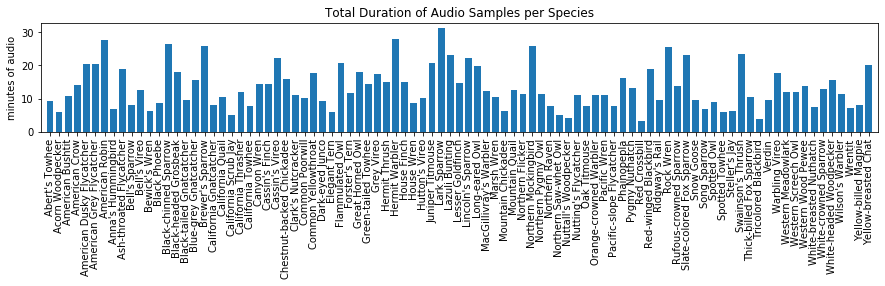

In [3]:
duration_by_class=[df.loc[df.english_cname==y,'duration_seconds'].sum()/60 
                   for y in label_encoder.classes_]
plt.figure(figsize=(15,2))
plt.title("Total Duration of Audio Samples per Species")
plt.bar(range(n_classes), duration_by_class, .75)
plt.ylabel("minutes of audio")
plt.xticks(range(n_classes), label_encoder.classes_, rotation='vertical')
plt.xlim(-1,91)
plt.show();

XC119222.mp3: Abert's Towhee (Melozone aberti), contributed by: Ryan P. O'Donnell https://www.xeno-canto.org/contributor/SDXVTLDNGJ


XC79575.mp3: American Grey Flycatcher (Empidonax wrightii), contributed by: Ryan P. O'Donnell https://www.xeno-canto.org/contributor/SDXVTLDNGJ


XC79577.mp3: Ash-throated Flycatcher (Myiarchus cinerascens cinerascens), contributed by: Ryan P. O'Donnell https://www.xeno-canto.org/contributor/SDXVTLDNGJ


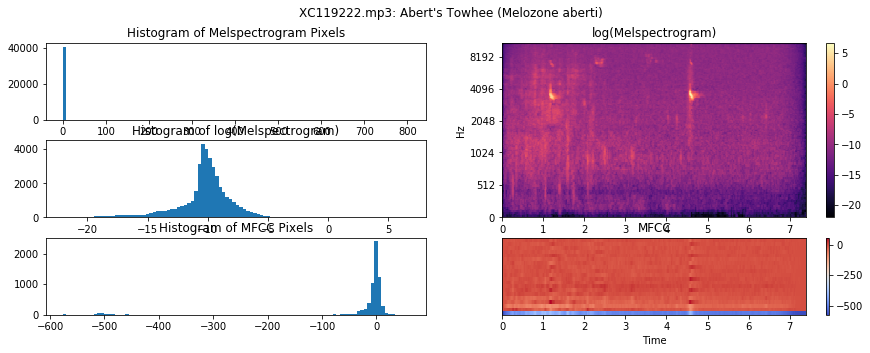

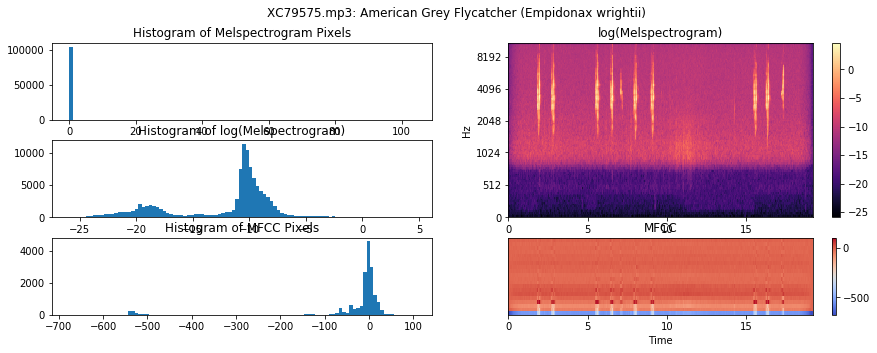

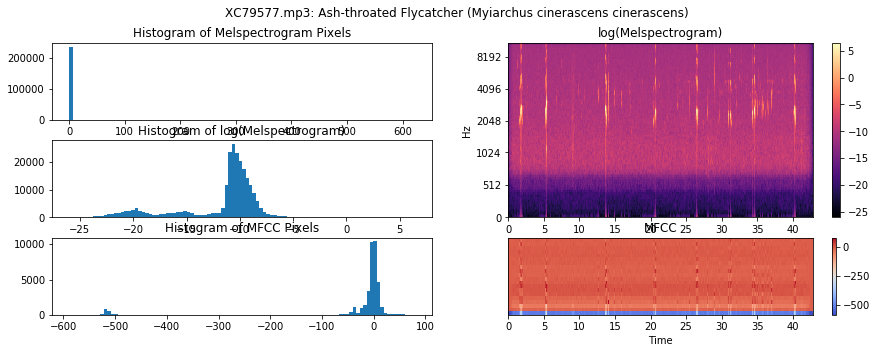

In [4]:
ryans_samples=df[df.recordist.str.contains('O\'Donnel')]
for i,sample in islice(ryans_samples.iterrows(),0,3):
# sample = df.loc[119160]
    print("%s: %s, contributed by: %s %s"%(
        sample.file_name,sample.full_name,sample.recordist,sample.recordist_url))
    data, samplerate = librosa.load(os.path.join(data_dir,sample.file_name))
    Audio(data, rate = samplerate)
    hop_length = 512
    sg = librosa.feature.melspectrogram(data, sr=samplerate, hop_length=hop_length, n_fft=2048)
    mfcc = librosa.feature.mfcc(data, sr=samplerate, hop_length=hop_length, n_fft=2048)
    fig = plt.figure(figsize=(15,5)); #plt.subplots_adjust(hspace=4)
    gs = GridSpec(12,2, fig, hspace=5) # get a grid of 12 rows x 2 cols
    fig.suptitle("%s: %s"%(sample.file_name, sample.full_name))
    hist_ax1 = fig.add_subplot(gs[0:4,0])
    hist_ax2 = fig.add_subplot(gs[4:8,0])
    mfcc_hist_ax = fig.add_subplot(gs[8:,0])
    sg_ax = fig.add_subplot(gs[:8,1])
    mfcc_ax = fig.add_subplot(gs[8:,1])
    hist_ax1.hist(sg.flatten(), bins=100)
    hist_ax1.set_title("Histogram of Melspectrogram Pixels")
    hist_ax2.hist(np.log(sg.flatten()), bins=100)
    hist_ax2.set_title("Histogram of log(Melspectrogram)")
    mfcc_hist_ax.hist(mfcc.flatten(), bins=100)
    mfcc_hist_ax.set_title("Histogram of MFCC Pixels")
    specshow(np.log(sg), y_axis='mel', x_axis='time', ax=sg_ax, hop_length=hop_length)
    sg_ax.set_title("log(Melspectrogram)")
    plt.colorbar(sg_ax.get_children()[0], ax=sg_ax)
    specshow(mfcc, x_axis='time', ax=mfcc_ax, hop_length=hop_length)
    mfcc_ax.set_title("MFCC")
    plt.colorbar(mfcc_ax.get_children()[0], ax=mfcc_ax)
    display(Audio(data, rate=samplerate))
    fig.show();

In [5]:
sg_dir = "data/features/"
sg_scaler = StandardScaler()
sg_log_scaler = StandardScaler()
ct=0
for file_id in df.index:
    shape = parse_shape(shapes_df[shapes_df.file_id==file_id]['melspectrogram_shapes'].values[0])
    sg = np.memmap('%s/XC%s_melspectrogram.dat'%(sg_dir,file_id), 
                   dtype='float32', mode='readonly', shape=shape).flatten()
    sg_scaler.partial_fit(sg.reshape(-1,1))
    sg_log_scaler = sg_log_scaler.partial_fit(log_clipped(sg).reshape(-1,1))
    ct+=shape[0]*shape[1]
print("Total number of melspectrogram pixels: %i, mean: %.5f, std. dev: %.5f"%(
    ct, sg_scaler.mean_, np.sqrt(sg_scaler.var_)))
print("log(melspectrogram_agg) mean: %.5f, std. dev: %.5f"%(
    sg_log_scaler.mean_, np.sqrt(sg_log_scaler.var_)))

Total number of melspectrogram pixels: 412313856, mean: 0.29080, std. dev: 15.13515
log(melspectrogram_agg) mean: -7.34926, std. dev: 3.56474


In [6]:
mfcc_dir = "data/features/"
mfcc_agg=np.array([])
mfcc_scaler = StandardScaler()
ct=0
for file_id in df.index:
    shape = parse_shape(shapes_df[shapes_df.file_id==file_id]['mfcc_shapes'].values[0])
    mfcc = np.memmap('%s/XC%s_mfcc.dat'%(mfcc_dir,file_id), 
                     dtype='float32', mode='readonly', shape=shape).flatten()
    mfcc_scaler.partial_fit(mfcc.reshape(-1,1))
    ct+=shape[0]*shape[1]
print("Total number of MFCC pixels: %i, mean: %.5f, std. dev: %.5f"%(
    ct,mfcc_scaler.mean_,np.sqrt(mfcc_scaler.var_)))  

Total number of MFCC pixels: 64424040, mean: -19.00330, std. dev: 86.45496


In [7]:
X_train = list(train_df.index)
y_train = list(train_df.label)
print("Training data len:",len(X_train))
X_test = list(test_df.index)
y_test = list(test_df.label)
print("Test data len:    ",len(X_test))

Training data len: 1820
Test data len:     910


In [8]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class AudioFeatureGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size, n_frames=128, n_channels=1,
                 n_classes=10, shuffle=False, seed=37):
        'Initialization'
        self.n_frames = n_frames
        self.dim = (128, self.n_frames)
        self.batch_size = batch_size
        self.labels = {list_IDs[i]:l for i,l in enumerate(labels)}
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Update indexes, to be called after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.seed)
            self.seed = self.seed+1 # increment the seed so we get a different batch.
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        #X = np.empty((self.batch_size, 128+20, self.dim[1], self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int) # one-hot encoded labels

        for i, ID in enumerate(list_IDs_temp):
#             sg_lognorm = np.memmap(sglog_dir+'XC%s_melspectrogram_logscaled_normalized.dat'%ID, 
#                     shape=parse_shape(shapes_df[shapes_df.file_id==ID]['melspectrogram_shapes'].values[0]),  
#                     dtype='float32', mode='readonly')
            sg = np.memmap(sg_dir+'XC%s_melspectrogram.dat'%ID, 
                    shape=parse_shape(shapes_df[shapes_df.file_id==ID]['melspectrogram_shapes'].values[0]),  
                    dtype='float32', mode='readonly')
            sg_lognorm = sg_log_scaler.transform(log_clipped(sg))
        
            mfcc = np.memmap(mfcc_dir+'XC%s_mfcc.dat'%ID, 
                    shape=parse_shape(shapes_df[shapes_df.file_id==ID]['mfcc_shapes'].values[0]),  
                    dtype='float32', mode='readonly')
            # Normalize MFCCs
            mfcc = mfcc_scaler.transform(mfcc)
            
            # Pick a random window from the sound file
            d_len = mfcc.shape[1] - self.dim[1]
            if d_len<0: # Clip is shorter than window, so pad with mean value.
                n = int(np.random.uniform(0, -d_len))
                pad_range = (n, -d_len-n) # pad with n values on the left, clip_length - n values on the right 
#                 sg_cropped = np.pad(sg, ((0,0), pad_range), 'constant', constant_values=sg.mean())
                sg_lognorm_cropped = np.pad(sg_lognorm, ((0,0), pad_range), 'constant', constant_values=0)
                mfcc_cropped = np.pad(mfcc, ((0,0), pad_range), 'constant', constant_values=0)
            else: # Clip is longer than window, so slice it up
                n = int(np.random.uniform(0, d_len))
#                 sg_cropped = sg[:, n:(n+self.dim[1])]
                sg_lognorm_cropped = sg_lognorm[:, n:(n+self.dim[1])]
                mfcc_cropped = mfcc[:, n:(n+self.dim[1])]
                
            # Stack the MFCCs and spectrograms to create a single array
            #X[i,] = np.concatenate([sg_lognorm_cropped.reshape(1,128,self.dim[1],1), 
            #                        mfcc_cropped.reshape(1,20,self.dim[1],1)], axis=1)
            #X[i,] = sg_lognorm_cropped.reshape(1,128,self.dim[1],1)
            X[i,] = sg_lognorm_cropped.reshape(1,128,self.dim[1],1)
            # Overwrite the bottom of X with MFCCs (we don't need the low frequency bands anyway) 
            X[i,:20] = mfcc_cropped.reshape(1,20,self.dim[1],1)
            y[i,] = to_categorical(self.labels[ID], num_classes=self.n_classes)

        return X, y


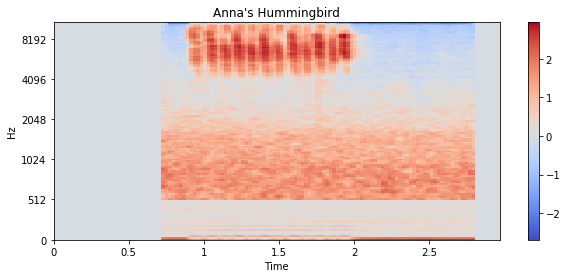

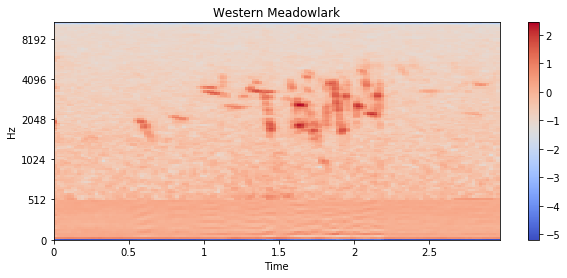

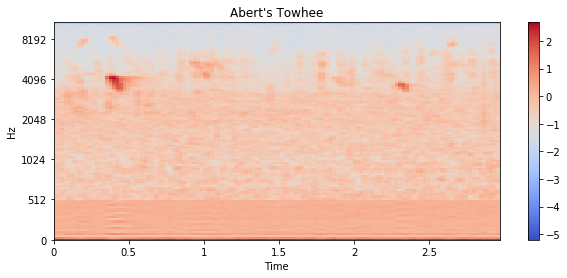

In [9]:
generator = AudioFeatureGenerator(X_train, y_train, 
            batch_size=3, shuffle=False, seed=37, n_frames=128, n_classes=n_classes)
# the 32nd batch happens to include a short sample that has been paded. Let's show it.
Xs, ys = generator[31] 
for X, y in list(zip(Xs, ys)): #(X,y for each of the 3 samples in the batch)
    plt.figure(figsize=(10,4))
    spec_ax = specshow(X.squeeze(), x_axis='time', y_axis='mel')
    plt.title(label_encoder.classes_[np.argmax(y)])
    plt.colorbar()
    plt.show()

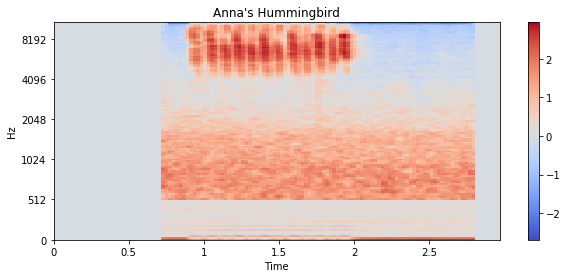

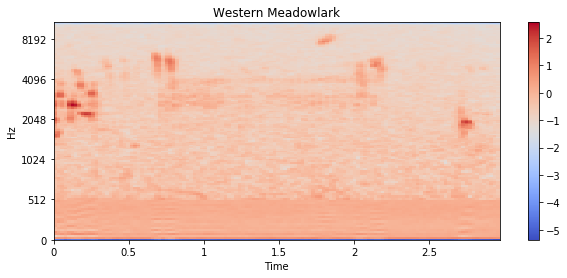

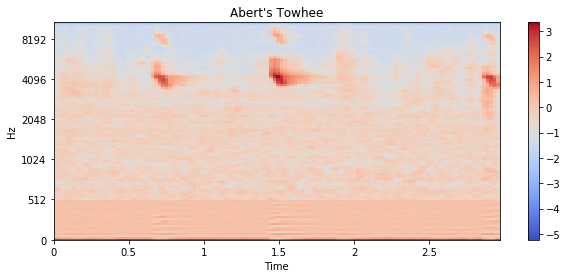

In [10]:
Xs, ys = generator[31] # Calling the generator again grabs a different random window.
for X, y in list(zip(Xs, ys)): 
    plt.figure(figsize=(10,4))
    spec_ax = specshow(X.squeeze(), x_axis='time', y_axis='mel')
    plt.title(label_encoder.classes_[np.argmax(y)])
    plt.colorbar()
    plt.show()

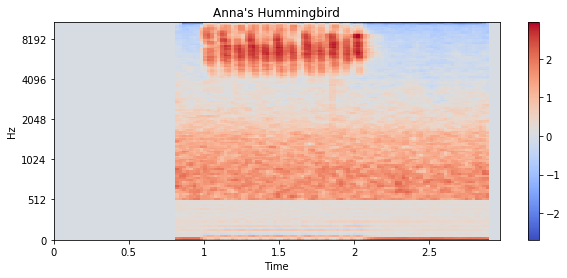

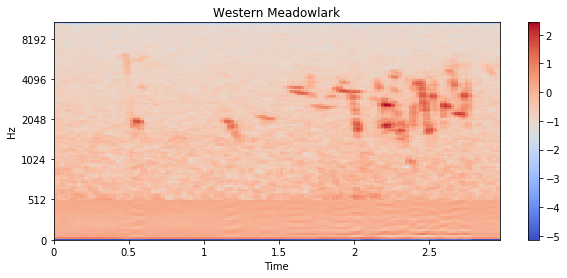

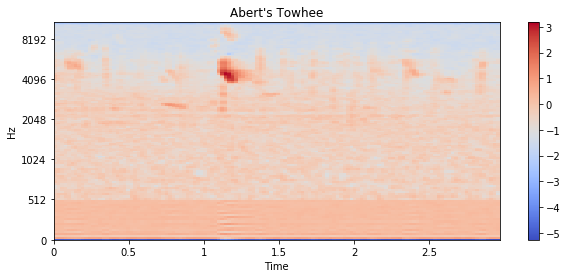

In [11]:
Xs, ys = generator[31] # Calling the generator again grabs a different random window.
for X, y in list(zip(Xs, ys)): 
    plt.figure(figsize=(10,4))
    spec_ax = specshow(X.squeeze(), x_axis='time', y_axis='mel')
    plt.title(label_encoder.classes_[np.argmax(y)])
    plt.colorbar()
    plt.show()

In [12]:
model = Sequential()
dim=(128,128)
model.add(Conv2D(64,3,input_shape=(dim[0], dim[1], 1),padding='valid',activation="relu"))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(rate=.2))
model.add(Conv2D(64,3,padding='valid',activation="relu"))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(rate=.2))
model.add(Conv2D(64,3,padding='valid',activation="relu"))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(rate=.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(n_classes, activation="softmax"))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 64)        0         
______________________

In [14]:
n_splits = 1
n_epochs = 2
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=1/4, random_state=37)
scores = []
params = {'n_frames': 128,
          'n_classes': n_classes,
          'n_channels': 1}
for cv_train_index, cv_val_index in sss.split(X_train, y_train):
    training_generator = AudioFeatureGenerator(
        [X_train[i] for i in cv_train_index], 
        [y_train[i] for i in cv_train_index], 
        batch_size=64, shuffle=True, seed=37, **params)
    validation_generator = AudioFeatureGenerator(
        [X_train[i] for i in cv_val_index], 
        [y_train[i] for i in cv_val_index], 
        batch_size=len(cv_val_index), **params)
    
    partial_filename = "cnn.split%02i"%len(scores)
    checkpointer = ModelCheckpoint(filepath='weights.best.%s.hdf5'%partial_filename, verbose=1, save_best_only=True)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    learning = model.fit_generator(
                training_generator, 
                validation_data=validation_generator,
                epochs=n_epochs, 
                steps_per_epoch=np.ceil(len(cv_train_index)/training_generator.batch_size),
                validation_steps=1,
                callbacks=[checkpointer], 
#                 use_multiprocessing=True, workers=4,
                verbose=0, )
#     pd.DataFrame(learning.history).to_csv('training_history_split%i.csv'%len(scores), index_label='epoch')
#     vis_learning_curve(learning)
#     plt.savefig("learning_curve.%s.png"%partial_filename)
#     plt.show()
    acc_at_min_loss = learning.history['val_acc'][np.argmin(learning.history['val_loss'])]
    scores.append(acc_at_min_loss)
    print("Split %i: min loss: %.5f, accuracy at min loss: %.5f"%(
        len(scores), np.min(learning.history['val_loss']), acc_at_min_loss ))
print("Cross Validation Accuracy: mean(val_acc[argmin(val_loss)]): %.4f"%(np.mean(scores)))


Epoch 00001: val_loss improved from inf to 4.48386, saving model to weights.best.cnn.split00.hdf5

Epoch 00002: val_loss improved from 4.48386 to 4.46921, saving model to weights.best.cnn.split00.hdf5
Split 1: min loss: 4.46921, accuracy at min loss: 0.01978
Cross Validation Accuracy: mean(val_acc[argmin(val_loss)]): 0.0198


In [15]:
model.load_weights("weights.best.cnn.split00.hdf5")
params = {'n_frames': 128,
          'n_classes': n_classes,
          'n_channels': 1}
test_generator = AudioFeatureGenerator(X_test, y_test, batch_size=len(X_test), 
                                       seed=37, **params)
X_batch, y_batch = test_generator[0]
predictions = model.predict(X_batch) 
y_predicted = [np.argmax(p) for p in predictions]
y_true = [np.argmax(y) for y in y_batch]
test_score = accuracy_score(y_true, y_predicted)
print("Test accuracy score: %.5f"%test_score)


Test accuracy score: 0.01429


In [16]:
test_scores = []
for i in range(3):
    X_batch, y_batch = test_generator[0]
    predictions = model.predict(X_batch) 
    y_predicted = [np.argmax(p) for p in predictions]
    y_true = [np.argmax(y) for y in y_batch]
    test_score = accuracy_score(y_true, y_predicted)
    print("Epoch %i test accuracy score: %.5f"%(i+1,test_score))
    test_scores.append(test_score)
print("Mean test score: %.5f, standard deviation: %.5f"%(
        np.mean(test_scores), np.std(test_scores)))

Epoch 1 test accuracy score: 0.01538
Epoch 2 test accuracy score: 0.01648
Epoch 3 test accuracy score: 0.01758
Mean test score: 0.01648, standard deviation: 0.00090


In [17]:
from requests import get
resp = get("https://www.xeno-canto.org/449570/download")
if resp.ok:
    with open('test_sample.mp3','wb') as f:
        
        f.write(resp.content)
else:
    raise("Error downloading sample. Do you have internet access?")
data, sr = librosa.load('test_sample.mp3')
display(Audio(data, rate=sr))

The vocalization is predicted to be from a Elegant Tern


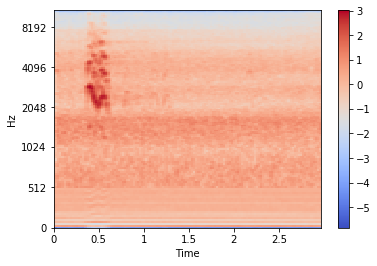

In [18]:
sg = librosa.feature.melspectrogram(data, sr=sr, hop_length=512, n_fft=2048)
sg_lognorm = sg_log_scaler.transform(np.log(sg))
mfcc = librosa.feature.mfcc(data, sr=sr, hop_length=512, n_fft=2048)
mfcc_norm = mfcc_scaler.transform(mfcc)
# Grab the first 128 frames
sg_lognorm_cropped = sg_lognorm[:, :128]
mfcc_norm_cropped = mfcc_norm[:, :128]
X = sg_lognorm_cropped.copy()
X[:20] = mfcc_norm_cropped
# Visualize it
specshow(X, x_axis='time', y_axis='mel')
plt.colorbar()
# Make a prediction
predictions = model.predict([X.reshape(1,*X.shape,1)])
predicted_label = label_encoder.classes_[np.argmax(predictions)]
print("The vocalization is predicted to be from a "+predicted_label)

In [20]:
import tensorflow
print("The following package versions were used in this notebook:")
for sym in dir():
    if hasattr(globals()[sym], '__version__'):
        print("{}=={}".format(globals()[sym].__name__, globals()[sym].__version__)) 

The following package versions were used in this notebook:
keras==2.2.4
keras==2.2.4
librosa==0.6.3
numpy==1.16.3
pandas==0.23.4
re==2.2.1
tensorflow==1.14.0
